#### Scraping Our Data

In [34]:
%reload_ext autoreload
%autoreload 2

In [35]:
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px
import requests
from bs4 import BeautifulSoup
import pandas as pd
from pathlib import Path
import sys

from src.paths import RAW_DATA_DIR

In [36]:
# Function to scrape the data
def scraper(base_url: str, start_page: int, end_page: int) -> pd.DataFrame:
    '''Scrape the website for all available reviews.'''
    reviews = []

    for page_num in range(start_page, end_page + 1):
        url = f"{base_url}/page/{page_num}/?sortby=post_date%3ADesc&pagesize=100"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        review_elements = soup.find_all('article', itemprop='review')

        for element in review_elements:
            review_data = {}

            # Define the verification status based on the presence of specific text
            if "✅ Trip Verified" in element.get_text():
                review_data['verification_status'] = "Trip Verified"
            elif "✅ Verified Review" in element.get_text():
                review_data['verification_status'] = "Review Verified"
            else:
                review_data['verification_status'] = "Not Verified"

            # Clean review body text
            review_body = element.find('div', class_='text_content').get_text(strip=True)
            review_body = review_body.replace("✅Trip Verified|", "").replace("✅Verified Review|", "").replace("Not Verified|", "").strip()
            review_data['review_body'] = review_body

            # Extract published date
            published_date = element.find('time', itemprop='datePublished')['datetime']
            review_data['published_date'] = published_date

            # Extract rating
            rating_element = element.find('div', itemprop='reviewRating')
            if rating_element:
                rating_value = rating_element.find('span', itemprop='ratingValue').get_text(strip=True)
                best_rating = rating_element.find('span', itemprop='bestRating').get_text(strip=True)
                review_data['rating'] = f"{rating_value}/{best_rating}"

            # Extract additional data
            rows = element.find_all('tr')
            for row in rows:
                header = row.find('td', class_='review-rating-header')
                value = row.find('td', class_='review-value')
                if header and value:
                    review_data[header.get_text(strip=True)] = value.get_text(strip=True)

            reviews.append(review_data)

    reviews_df = pd.DataFrame(reviews)
    return reviews_df

# Define the base URL and page range
base_url = 'https://www.airlinequality.com/airline-reviews/british-airways'
start_page = 1
end_page = 40

# call the function
reviews_df = scraper(base_url, start_page, end_page)

In [37]:
reviews_df.head()

,verification_status,review_body,published_date,rating,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Recommended
0,Not Verified,Very good flight following an equally good fli...,2025-01-20,9/10,A320,Solo Leisure,Business Class,London Heathrow to Zurich,January 2025,yes
1,Not Verified,An hour's delay due to late arrival of the inc...,2025-01-19,7/10,A319,Family Leisure,Economy Class,London to Lisbon,January 2025,yes
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1/10,NaN,Solo Leisure,Economy Class,Manchester to Isle of Man,November 2024,no
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1/10,NaN,Family Leisure,Premium Economy,Houston to cologne via London,December 2024,no
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1/10,A320,Business,Economy Class,London to Basel,January 2025,no


In [38]:
# save to raw data folder
reviews_df.to_parquet(RAW_DATA_DIR / 'existing_reviews.parquet')

In [39]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   verification_status  3911 non-null   object
 1   review_body          3911 non-null   object
 2   published_date       3911 non-null   object
 3   rating               3906 non-null   object
 4   Aircraft             2037 non-null   object
 5   Type Of Traveller    3140 non-null   object
 6   Seat Type            3909 non-null   object
 7   Route                3135 non-null   object
 8   Date Flown           3133 non-null   object
 9   Recommended          3911 non-null   object
dtypes: object(10)
memory usage: 305.7+ KB


In [40]:
# check for new data
def check_and_update_reviews(base_url: str, start_page: int, end_page: int, existing_reviews_df: pd.DataFrame, current_date: str) -> pd.DataFrame:
    '''Scrape the webpage for new reviews and update the DataFrame with unique reviews.'''
    # # use our scraper function but only scrape the first page
    new_reviews_df = scraper(base_url, start_page, end_page)
    
    # # should have a full page of reviews
    if new_reviews_df.empty:
        print("No reviews scraped or DataFrame is empty.")
        return existing_reviews_df

    # Combine new reviews with existing reviews
    combined_reviews_df = pd.concat([existing_reviews_df, new_reviews_df], ignore_index=True)
    
    # Sort by published_date in ascending order to keep the oldest reviews when we drop duplicates
    combined_reviews_df['published_date'] = pd.to_datetime(combined_reviews_df['published_date'])
    combined_reviews_df = combined_reviews_df.sort_values(by='published_date', ascending=True)

    # Identify and remove duplicates, keeping the first occurrence (oldest date)
    unique_reviews_df = combined_reviews_df.drop_duplicates(subset=['review_body'], keep='first')

    # Identify new unique reviews - this will be empty if there are no new reviews
    new_unique_reviews_df = unique_reviews_df[~unique_reviews_df['review_body'].isin(existing_reviews_df['review_body'])]

    if new_unique_reviews_df.empty:
        print("No new unique reviews found.")
        return existing_reviews_df
    else:
        print("New unique reviews found.")
        
        # Save new unique reviews to a new DataFrame with the current date in the filename
        new_reviews_filename = RAW_DATA_DIR / f'new_unique_reviews_{current_date}.parquet'
        new_unique_reviews_df.to_parquet(new_reviews_filename, index=False)
        print(f"New unique reviews saved to '{new_reviews_filename}'.")

        # Update existing reviews DataFrame by concatenating with new unique reviews and dropping duplicates
        updated_reviews_df = pd.concat([existing_reviews_df, new_unique_reviews_df], ignore_index=True).drop_duplicates(subset=['review_body'], keep='first')
        updated_reviews_filename = RAW_DATA_DIR / 'existing_reviews.parquet'
        updated_reviews_df.to_parquet(updated_reviews_filename, index=False)
        print("Existing reviews DataFrame updated.")
        
        return updated_reviews_df


# call the function but only scrape page 1
start_page = 1
end_page = 1
existing_reviews_df = pd.read_parquet(RAW_DATA_DIR / 'existing_reviews.parquet')
current_date = datetime.now().strftime('%Y-%m-%d')
updated_reviews_df = check_and_update_reviews(base_url, start_page, end_page, existing_reviews_df, current_date)



No new unique reviews found.


In [41]:
# make sure we can read it in
reviews_df = pd.read_parquet(RAW_DATA_DIR / 'existing_reviews.parquet')
reviews_df.head()

,verification_status,review_body,published_date,rating,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Recommended
0,Not Verified,Very good flight following an equally good fli...,2025-01-20,9/10,A320,Solo Leisure,Business Class,London Heathrow to Zurich,January 2025,yes
1,Not Verified,An hour's delay due to late arrival of the inc...,2025-01-19,7/10,A319,Family Leisure,Economy Class,London to Lisbon,January 2025,yes
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1/10,None,Solo Leisure,Economy Class,Manchester to Isle of Man,November 2024,no
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1/10,None,Family Leisure,Premium Economy,Houston to cologne via London,December 2024,no
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1/10,A320,Business,Economy Class,London to Basel,January 2025,no


### EDA 

It appears that all of our data are **object** types but the rating should be a numeric value. We also see that some of the columns are capital and include spaces from when we scraped the data table and the variables we created are lowercase with underscores so we can change them to a standard format.

In [42]:
# function to rename columns
def rename_cols(reviews_df: pd.DataFrame) -> pd.DataFrame:
    '''Change column names to snake case.'''
    return reviews_df.rename(columns={
        'Aircraft': 'aircraft',
        'Type Of Traveller': 'type_of_traveler', 
        'Seat Type': 'seat_type', 
        'Route': 'route', 
        'Date Flown': 'date_flown', 
        'Recommended': 'recommended'},
        inplace=True
)

In [43]:
# rename the columns using the function
rename_cols(reviews_df)

In [44]:
# check they have been renamed
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   verification_status  3911 non-null   object
 1   review_body          3911 non-null   object
 2   published_date       3911 non-null   object
 3   rating               3906 non-null   object
 4   aircraft             2037 non-null   object
 5   type_of_traveler     3140 non-null   object
 6   seat_type            3909 non-null   object
 7   route                3135 non-null   object
 8   date_flown           3133 non-null   object
 9   recommended          3911 non-null   object
dtypes: object(10)
memory usage: 305.7+ KB


In [45]:
reviews_df.describe()

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,route,date_flown,recommended
count,3911,3911,3911,3906,2037,3140,3909,3135,3133,3911
unique,3,3894,1981,10,212,4,4,1633,126,2
top,Not Verified,British Airways from Tampa to Gatwick on Boein...,2015-01-19,1/10,A320,Couple Leisure,Economy Class,London to Johannesburg,August 2015,no
freq,1837,2,26,949,394,1057,2045,21,83,2354


In [46]:
reviews_df['verification_status'].value_counts()

verification_status
Not Verified       1837
Trip Verified      1304
Review Verified     770
Name: count, dtype: int64

#### Route and Date Flown

We have the **published_date** which we will use as the date in our analysis so we can remove the **date_flown** column from the data. We can also remove **route** since there are 1633 unique values here.

In [47]:
reviews_df.drop(columns=['route', 'date_flown'], axis=1, inplace=True)

The **review_body** column has 3911 reviews but only 3896 unique values meaning we have duplicates. We can inspect and remove them.

In [48]:
# find the duplicate reviews and inspect them
duplicate_review_body = reviews_df[reviews_df.duplicated(subset=['review_body'], keep=False)]
duplicate_review_body.sort_values('review_body')

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended
3601,Not Verified,BA26 22/6/2014. During my trip to the UK I fee...,2014-10-05,7/10,None,None,Economy Class,yes
3596,Not Verified,BA26 22/6/2014. During my trip to the UK I fee...,2014-10-05,7/10,None,None,Economy Class,yes
3801,Not Verified,BKK to LHR in club world 777-200 seat 3E and 3...,2014-06-16,10/10,None,None,Business Class,yes
3797,Not Verified,BKK to LHR in club world 777-200 seat 3E and 3...,2014-06-16,10/10,None,None,Business Class,yes
2739,Not Verified,British Airways from Tampa to Gatwick on Boein...,2015-12-01,8/10,Boeing 777,Couple Leisure,Business Class,yes
2767,Not Verified,British Airways from Tampa to Gatwick on Boein...,2015-11-20,8/10,Boeing 777,Couple Leisure,Business Class,yes
3899,Not Verified,Business LHR to BKK. 747-400. First try back w...,2012-08-29,4/10,None,None,Business Class,no
3902,Not Verified,Business LHR to BKK. 747-400. First try back w...,2012-08-29,4/10,None,None,Business Class,no
3489,Not Verified,Dallas Fort Worth Texas to London Heathrow BA ...,2014-11-20,4/10,None,None,Economy Class,no
3505,Not Verified,Dallas Fort Worth Texas to London Heathrow BA ...,2014-11-20,4/10,None,None,Economy Class,no


In [49]:
print(len(duplicate_review_body))

34


When we check the duplicates for the entire dataset we are getting a number smaller (26) than our number for the reviews (30). After inspection, we see that these reviews came in on different dates so that is the reason there are less for the entire dataset. Having a different date posted causes them not to be duplicates. We will remove the duplicates and keep the one with the oldest date. When we scraped the data we were using their filter which had them sorted by date from newest to oldest so we will sort them from oldest to newest to keep the oldest duplicate.

In [50]:
# Identify duplicate rows based on the entire dataset
duplicate_rows = reviews_df[reviews_df.duplicated(keep=False)]

# Display the duplicate rows
print(len(duplicate_rows))


30


In [51]:
# remove duplicates and keep the oldest review - sort by published date
reviews_df['published_date'] = pd.to_datetime(reviews_df['published_date'])
# sort by published date
reviews_df.sort_values('published_date', inplace=True)
# remove duplicates
reviews_df.drop_duplicates(subset='review_body', keep='first', inplace=True)


In [52]:
# now there should be 3904 reviews since there were 3904 unique reviews
len(reviews_df)

3894

In [53]:
# sort by published date with most recent being first
reviews_df.sort_values('published_date', ascending=False, inplace=True) 
reviews_df.head()

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended
0,Not Verified,Very good flight following an equally good fli...,2025-01-20,9/10,A320,Solo Leisure,Business Class,yes
1,Not Verified,An hour's delay due to late arrival of the inc...,2025-01-19,7/10,A319,Family Leisure,Economy Class,yes
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1/10,None,Solo Leisure,Economy Class,no
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1/10,None,Family Leisure,Premium Economy,no
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1/10,A320,Business,Economy Class,no


In [54]:
# reset the index
reviews_df.reset_index(drop=True, inplace=True)

In [55]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3894 entries, 0 to 3893
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   verification_status  3894 non-null   object        
 1   review_body          3894 non-null   object        
 2   published_date       3894 non-null   datetime64[ns]
 3   rating               3889 non-null   object        
 4   aircraft             2035 non-null   object        
 5   type_of_traveler     3138 non-null   object        
 6   seat_type            3892 non-null   object        
 7   recommended          3894 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 243.5+ KB


In [56]:
reviews_df.describe(include='all')

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended
count,3894,3894,3894,3889,2035,3138,3892,3894
unique,3,3894,NaN,10,212,4,4,2
top,Not Verified,SIN-LHR BA12 B747-436 First Class. Old aircraf...,NaN,1/10,A320,Couple Leisure,Economy Class,no
freq,1820,1,NaN,948,394,1055,2037,2346
mean,NaN,NaN,2018-02-03 21:53:09.522341888,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2011-10-09 00:00:00,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2015-09-19 00:00:00,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2017-04-09 12:00:00,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2019-09-16 00:00:00,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,2025-01-20 00:00:00,NaN,NaN,NaN,NaN,NaN


The rating column are reviews based on a scale from 1-10 so we can convert this to a numeric value, however, there are some missing values (5) so we will have to check these out first.

#### Rating Variable

In [57]:
# Filter the DataFrame to find rows with NaN values in the 'review' column
nan_reviews = reviews_df[reviews_df['rating'].isna()]
nan_reviews

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended
3334,Not Verified,Cabin crew polite unfortunately BA ran out of ...,2015-02-18,None,None,None,Economy Class,no
3462,Not Verified,Phoenix to London - outbound a wonderful and e...,2014-12-10,None,None,None,First Class,no
3479,Not Verified,On past experience I chose BA for our long hau...,2014-11-25,None,None,None,Economy Class,no
3709,Not Verified,LHR-CPH-LHR Business Class. This is a joke. Sc...,2014-07-31,None,None,None,Business Class,no
3738,Not Verified,I flew with British Airways with my mother fro...,2014-07-15,None,None,None,Economy Class,no


Although there are NaN values for the following 5 reviews we can see that they are all bad reviews. This means we can inpute a value here knowing that the review would not be plesent. Looking at the **value_counts** for the ratings most ratings are 1/10 and these ratings seem to fit a 1/10 rating as well so we will impute that value for them.

In [58]:
for review in nan_reviews['review_body']:
    print(f'{review}\n')

Cabin crew polite unfortunately BA ran out of chicken ran out of wine ran out of soft drinks. The food was awful. Inflight service was a disaster - did not work properly. 12 hours 20 mins flight everything counts obviously BA overlooked this. To be fair all cabin crew were polite and accommodating. I will never fly again with BA.

Phoenix to London - outbound a wonderful and enjoyable experience. The problem we had started on our return flight home. We boarded the plane and were disappointed to find out that we were in the old style first class. After being in the new cabin on the way out the old configuration is very run down and there was a rip in the seat. I was attempting to work but when I went to plug in my laptop battery I found that there was no adapter for me to use. Since I could no longer work I decided to put a movie on. The tiny screen in the old first class was just pathetic. The flight attendants did their absolute best to make up for the issues and I give them high mark

In [59]:
reviews_df['rating'].value_counts()

rating
1/10     948
2/10     443
3/10     429
8/10     386
10/10    336
9/10     322
7/10     321
4/10     263
5/10     243
6/10     198
Name: count, dtype: int64

In [60]:
# fill the empty ratings with a 1/10
reviews_df['rating'] = reviews_df['rating'].fillna('1/10')

In [61]:
# no more missing values
reviews_df[reviews_df['rating'].isna()]

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended


In [62]:
reviews_df['rating'].value_counts()

rating
1/10     953
2/10     443
3/10     429
8/10     386
10/10    336
9/10     322
7/10     321
4/10     263
5/10     243
6/10     198
Name: count, dtype: int64

In [63]:
# Function to convert rating to float
def convert_rating(rating: str) -> float:
    '''Convert rating to float.'''
    # Split the string on '/' and take the first part
    numerator = rating.split('/')[0]  
    return float(numerator)

# Apply the function to the 'rating' column
reviews_df['rating'] = reviews_df['rating'].apply(convert_rating)

reviews_df.head()

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended
0,Not Verified,Very good flight following an equally good fli...,2025-01-20,9.0,A320,Solo Leisure,Business Class,yes
1,Not Verified,An hour's delay due to late arrival of the inc...,2025-01-19,7.0,A319,Family Leisure,Economy Class,yes
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1.0,None,Solo Leisure,Economy Class,no
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1.0,None,Family Leisure,Premium Economy,no
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1.0,A320,Business,Economy Class,no


In [64]:
(reviews_df['rating']).describe()

count    3894.000000
mean        4.667180
std         3.176892
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        10.000000
Name: rating, dtype: float64

#### Verification Status

In [65]:
# mean rating per verification status
reviews_df.groupby('verification_status')['rating'].mean()

verification_status
Not Verified       5.242308
Review Verified    4.090909
Trip Verified      4.204755
Name: rating, dtype: float64

In [66]:
# verification status counts normalized
reviews_df['verification_status'].value_counts(normalize=True)

verification_status
Not Verified       0.467386
Trip Verified      0.334874
Review Verified    0.197740
Name: proportion, dtype: float64

In [67]:
# plot the ratings by year
reviews_df['year'] = reviews_df['published_date'].dt.year
reviews_df['month'] = reviews_df['published_date'].dt.month
reviews_df['day'] = reviews_df['published_date'].dt.day


#### Publication Date

On average, about 2 reviews are posted on the same day. We also see that the number of reviews posted have decreased after a boom in 2014. This also happens to be the year where the average rating was the highest. Overtime, the ratings have diminished from a max of 6.2 to the current value of 4.7. This year has the smallest average rating but only has a total of 8 reviews thus far so we cannot say too much about it. If we look back one year to 2024, we made improvements on 2023, but the average rating was still down from previous years.

In [68]:
reviews_df['year'].value_counts() 

year
2015    734
2017    572
2016    570
2014    458
2019    356
2018    324
2023    280
2022    213
2024    176
2020    104
2021     87
2012      9
2025      8
2011      3
Name: count, dtype: int64

In [69]:
# publication date counts
publication_date_counts = reviews_df['published_date'].dt.date.value_counts().sort_index()
publication_date_counts.mean()

np.float64(1.9656739020696619)

In [70]:
# plot the publication date counts using plotly line plot
fig = px.line(publication_date_counts, title='Publication Date Counts')
fig.update_xaxes(title_text='Date')


In [71]:
# get the averages for each year
def yearly_avg(df: pd.DataFrame) -> pd.DataFrame:
    '''Function to return the yearly average rating.'''
    return df.groupby('year')['rating'].mean().reset_index()



In [72]:
reviews_df['year'].value_counts()

year
2015    734
2017    572
2016    570
2014    458
2019    356
2018    324
2023    280
2022    213
2024    176
2020    104
2021     87
2012      9
2025      8
2011      3
Name: count, dtype: int64

There are no reviews during 2013. I double checked the website and this is true on the website as well.

In [73]:
# get the yearly averages
yearly = yearly_avg(reviews_df)
# plot using plotly bar plot
fig = px.bar(
            yearly,
            x='year',
            y='rating', 
            title='Average Rating by Year'
)
fig.show()

In [74]:
# Sort by 'published_date'
reviews_df = reviews_df.sort_values('published_date')

# Calculate cumulative average rating
reviews_df['cumulative_avg_rating'] = reviews_df['rating'].expanding().mean()

# Use Plotly to graph
fig = px.line(
    reviews_df, 
    x='published_date', 
    y='cumulative_avg_rating',
    title='Cumulative Average Rating Over Time'
)

# Show the figure
fig.show()


In [75]:
reviews_df['cumulative_avg_rating'].max()

np.float64(6.238532110091743)

#### Customer Type

In [76]:
# plot ratings by customer type
fig = px.box(reviews_df, x='type_of_traveler', y='rating', title='Ratings by Customer Type')
fig.show()

In [77]:
# plot ratings by customer type
fig = px.box(reviews_df, x='seat_type', y='rating', title='Ratings by Seat Type')
fig.show()

In [78]:
reviews_df.sort_values('published_date', ascending=False, inplace=True)

In [79]:
reviews_df.head()

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended,year,month,day,cumulative_avg_rating
0,Not Verified,Very good flight following an equally good fli...,2025-01-20,9.0,A320,Solo Leisure,Business Class,yes,2025,1,20,4.667180
1,Not Verified,An hour's delay due to late arrival of the inc...,2025-01-19,7.0,A319,Family Leisure,Economy Class,yes,2025,1,19,4.666067
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1.0,None,Solo Leisure,Economy Class,no,2025,1,15,4.665468
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1.0,None,Family Leisure,Premium Economy,no,2025,1,9,4.666410
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1.0,A320,Business,Economy Class,no,2025,1,5,4.667352


In [80]:
# sort by aircraft and get rating average
aircraft_avg = reviews_df.groupby('aircraft')['rating'].mean().sort_values(ascending=False)

In [81]:
reviews_df['aircraft'].value_counts()   

aircraft
A320              394
Boeing 777        286
Boeing 747-400    181
A380              179
Boeing 777-200    129
                 ... 
777-200             1
boeing 787          1
Airbus 319          1
777-300             1
B747                1
Name: count, Length: 212, dtype: int64

#### Seat Type

In [82]:
# seat type and rating
seat_avg = reviews_df.groupby('seat_type')['rating'].mean().sort_values(ascending=False)

In [83]:
seat_avg

seat_type
First Class        5.986111
Business Class     5.101346
Premium Economy    4.795213
Economy Class      4.236622
Name: rating, dtype: float64

#### Recommended

<Axes: xlabel='recommended'>

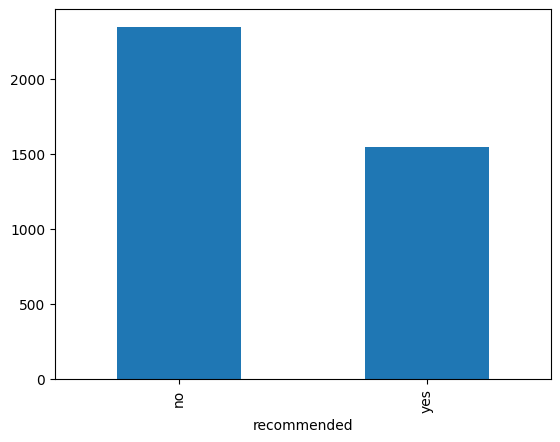

In [84]:
reviews_df['recommended'].value_counts().plot(kind='bar')

In [85]:
# Create a count plot using Plotly
fig = px.histogram(
    reviews_df, 
    x='rating', 
    color='recommended', 
    barmode='group',
    histfunc='count',
    title='Count of Recommendations by Rating'
)

# Customize the layout
fig.update_layout(
    xaxis_title='Rating',
    yaxis_title='Count',
    legend_title='Recommend'
)

# Show the figure
fig.show()


Add a plot or graph or table or print statement where we can see the percentage of each rating that answered no and yes

In [86]:
contingency_table = pd.crosstab(reviews_df['rating'], reviews_df['recommended'])
contingency_table

recommended,no,yes
rating,,
1.0,948,5
2.0,438,5
3.0,423,6
4.0,245,18
5.0,182,61
6.0,61,137
7.0,34,287
8.0,12,374
9.0,1,321


The rankings of 5 and 6 seem to be somewhat split but anything below a 5 is **not recommended** and anything above a 6 is **recommended**. We can use recommended as a target variable for our sentiment analysis. When we look at the value counts per rating, we can change anything below a 5 to be **not recommended** and anything above a 6 to be **recommended** and leave the 5 and 6 ratings as is since they are somewhat split. There were 5 people who reported a yes for recommended even though they gave it a 1 rating and 2 people would not recommend even though they gave it a 10 rating. These can be reporting errors since they do not reflect one another. 

In [87]:
normalized = pd.crosstab(reviews_df['rating'], reviews_df['recommended'], normalize='index')
normalized

recommended,no,yes
rating,,
1.0,0.994753,0.005247
2.0,0.988713,0.011287
3.0,0.986014,0.013986
4.0,0.931559,0.068441
5.0,0.748971,0.251029
6.0,0.308081,0.691919
7.0,0.105919,0.894081
8.0,0.031088,0.968912
9.0,0.003106,0.996894


As we would expect, there is a high correlation between the rating and the recommended variables. 

In [88]:
recommended_num = reviews_df.copy()

# Convert 'recommended' to numeric
recommended_num['recommended_numeric'] = recommended_num['recommended'].apply(lambda x: 1 if x == 'yes' else 0)

# Calculate the correlation
correlation = recommended_num[['rating', 'recommended_numeric']].corr().iloc[0, 1]

print("Correlation between Rating and Recommended:", correlation)


Correlation between Rating and Recommended: 0.8651738142141056


All of the reviews that have a 1 but put yes as recommended should be changed to no for recommended.

In [89]:
rating_1_recommended = reviews_df.loc[(reviews_df['rating'] == 1) & (reviews_df['recommended'] == 'yes')]
for review in rating_1_recommended['review_body']:
    print(f'{review}\n')

Singapore to Heathrow. Business class on an A380-800 is a Premium Economy Plus experience. From the economy class sized toilets to the badly designed coffin shaped Business class pods - the experience is a substandard business class experience. Business class pod’s storage is a small drawer at the FOOT of the pod. The ‘privacy’ screens are opaque plastic sheets - so you are kept awake by your neighbour as their screen lights up your pod. When the seat is made into its coffin shaped bed - the cold hard plastic seat moulds are an unpleasant surprise for those that turn in their sleep. You have a choice of having your neighbour step over your calf-height footrest - hopefully not brushing your feet with theirs - or having to step over your neighbour's feet/footrest. With the footrest down - heaven-forbid you try to lever yourself into a more comfortable position as the slightest pressure causes the footrest to collapse into its floor level position. If you are in the aisle seat - which is 

One of these should be yes for recommended but the other one has a rating that is misleading since it was a bad review but scored a 10. For our sentiment analysis we are only going to be using the recommended column as our target variable so we can change the first review here. Since there are too many reviews to comb through we will have to make a judgement call for the rest of them. Judging by our plot and contingency table, it seems like we can change all **recommended** values to **no** for those that scored less than or equal to 5. We will keep all other reviews untouched.

In [90]:
rating_10_not_recommended = reviews_df.loc[(reviews_df['rating'] == 10) & (reviews_df['recommended'] == 'no')]
for review in rating_10_not_recommended['review_body']:
    print(f'{review}\n')

Hyderabad to San Francisco via London. I had an awesome experience with one of customer service representatives at British Airways. I called them with regards to a reimbursement and was put across a lady named Florencia. She not only helped gather all details (bank, address etc) required for payment but also initiated the payment instantly. That was certainly over and beyond what I expected. Great job! Your service is exemplary.

Paris CDG to London. It is difficult to find anything positive to write about BA. Flight delayed, not their fault, but for nearly an hour the staff didn't communicate or interact with the cabin. They had a good old chat at the front one even deciding it was time to snooze. For a 700 dollar 45 minute flight we should get better. We just seem to be an inconvenience as passengers and no one cares that an extra 1 hour on the ground in a unclean aircraft. Terrible and not worth the money.



In [91]:
# change index 932 to a yes for recommended in the reviews_df
reviews_df.at[932, 'recommended'] = 'yes'

In [92]:
# verify the change
reviews_df.iloc[931,:]

verification_status                                          Trip Verified
review_body              Hyderabad to San Francisco via London. I had a...
published_date                                         2019-10-25 00:00:00
rating                                                                10.0
aircraft                                                              None
type_of_traveler                                                  Business
seat_type                                                    Economy Class
recommended                                                            yes
year                                                                  2019
month                                                                   10
day                                                                     25
cumulative_avg_rating                                             4.927727
Name: 932, dtype: object

In [93]:
# change all recommended to no if rating is <= 5
reviews_df.loc[reviews_df['rating'] <= 5, 'recommended'] = 'no'

In [94]:
# updated plot
# Create a count plot using Plotly
fig = px.histogram(
    reviews_df, 
    x='rating', 
    color='recommended', 
    barmode='group',
    histfunc='count',
    title='Count of Recommendations by Rating'
)

# Customize the layout
fig.update_layout(
    xaxis_title='Rating',
    yaxis_title='Count',
    legend_title='Recommend'
)

# Show the figure
fig.show()

These reviews seem to be poor but the rating is high. This is just one of those things that we have to make a call on if we are using supervised sentiment analysis. Since the rating is not our target variable we can just leave these as is. Another option would be to use unsupervised learning if we do not trust the **recommended** or **rating** variables but we will try it out.

In [95]:
# recommended seems correct, review does not
eight_plus = reviews_df.loc[(reviews_df['rating'] >= 8) & (reviews_df['recommended'] == 'no')]
for review in eight_plus['review_body']:
    print(f'{review}\n')

I am surprised to be able to give a favourable review of the flight. European Business Class is typically 3x3 seating with the middle seat on each group of three left empty. Leg room is never generous and BA is at the bottom of the generous barrel in this respect. However, on this occasion at least and as the flight is one hour that was not an issue. Cabin crew were great, very professional and efficient, cabin was clean and aircraft seemed pretty up to date. I was surprised to find that business class was served an 'afternoon tea' complete with champagne (much nicer than the poor Prosecco in the lounge). We had three small sandwiches, chocolate cake and a choice of plain or fruit scone. Strawberry jam and clotted cream on the side for those who wanted them. It all tasted great, I didn't try the chocolate cake, and there was just about enough time to eat it before landing. The crew worked very hard to complete service in time so well done them.

Fast and friendly check in (total contra

In [96]:
monthly_avg = reviews_df.groupby('month')['rating'].mean().reset_index()
monthly_avg

,month,rating
0,1,4.693878
1,2,4.691304
2,3,4.436620
3,4,4.651316
4,5,5.096774
5,6,4.594595
6,7,4.373089
7,8,4.659306
8,9,4.596439
9,10,4.703608


In [97]:
#months do not matter
fig = px.bar(
    monthly_avg,
    x='month',
    y='rating',
    title='Average Rating by Month'
)
fig.show()

In [98]:
# Concatenate all reviews into a single string
all_reviews = ' '.join(reviews_df['review_body'].tolist())

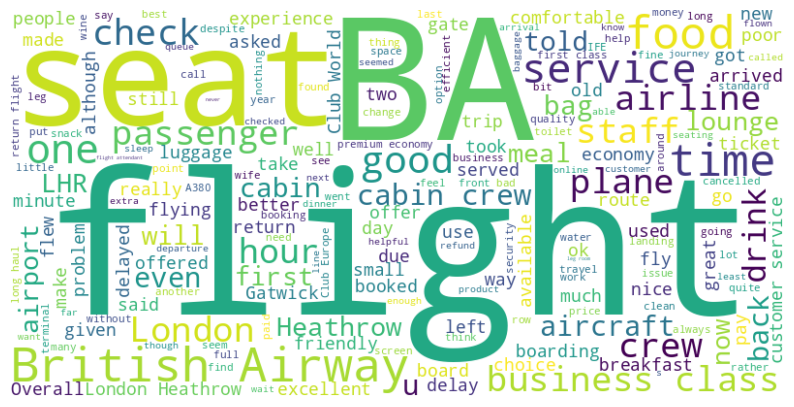

In [99]:
from wordcloud import WordCloud
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_reviews)

# Display the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


This wordcloud doesn't do us much good so we can split the reviews by recommended or not.

In [100]:
# not recommended
not_recommended = reviews_df[reviews_df['recommended']== 'no']
not_recommended

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended,year,month,day,cumulative_avg_rating
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1.0,None,Solo Leisure,Economy Class,no,2025,1,15,4.665468
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1.0,None,Family Leisure,Premium Economy,no,2025,1,9,4.666410
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1.0,A320,Business,Economy Class,no,2025,1,5,4.667352
5,Trip Verified,"We flew in November 2023, but it took this lon...",2025-01-04,1.0,None,Family Leisure,Economy Class,no,2025,1,4,4.668295
6,Trip Verified,I left for London from Johannesburg at 21:15 o...,2025-01-03,1.0,None,Family Leisure,Economy Class,no,2025,1,3,4.669239
...,...,...,...,...,...,...,...,...,...,...,...,...
3886,Not Verified,Flight from Heathrow to Toronto. Booked emerge...,2012-08-29,7.0,None,None,Economy Class,no,2012,8,29,4.857143
3887,Not Verified,Business LHR to BKK. 747-400. First try back w...,2012-08-29,4.0,None,None,Business Class,no,2012,8,29,4.500000
3891,Not Verified,My son who had worked for British Airways urge...,2011-10-12,5.0,None,None,Economy Class,no,2011,10,12,4.333333
3892,Not Verified,London City-New York JFK via Shannon on A318 b...,2011-10-11,4.0,None,None,Premium Economy,no,2011,10,11,4.000000


In [101]:
not_recommended.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2440 entries, 2 to 3893
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   verification_status    2440 non-null   object        
 1   review_body            2440 non-null   object        
 2   published_date         2440 non-null   datetime64[ns]
 3   rating                 2440 non-null   float64       
 4   aircraft               1146 non-null   object        
 5   type_of_traveler       2094 non-null   object        
 6   seat_type              2438 non-null   object        
 7   recommended            2440 non-null   object        
 8   year                   2440 non-null   int32         
 9   month                  2440 non-null   int32         
 10  day                    2440 non-null   int32         
 11  cumulative_avg_rating  2440 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int32(3), object(6)
memory usage:

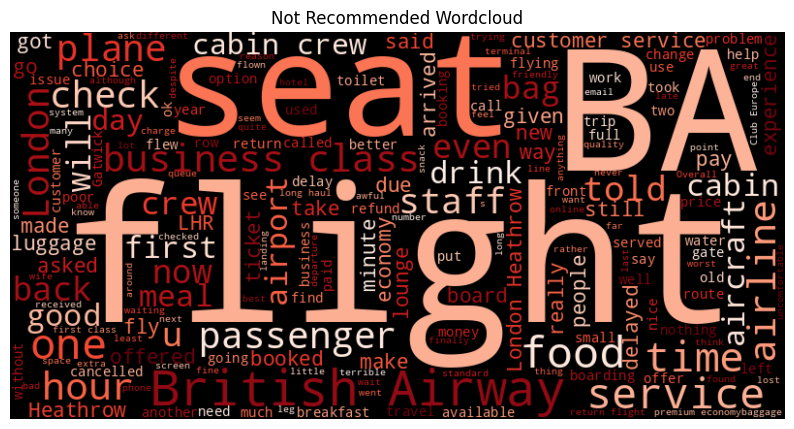

In [102]:
# wordcloud for not recommended reviews
not_recommended_reviews = ' '.join(not_recommended['review_body'].tolist())
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(not_recommended_reviews)

# Display the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Not Recommended Wordcloud')
plt.show()

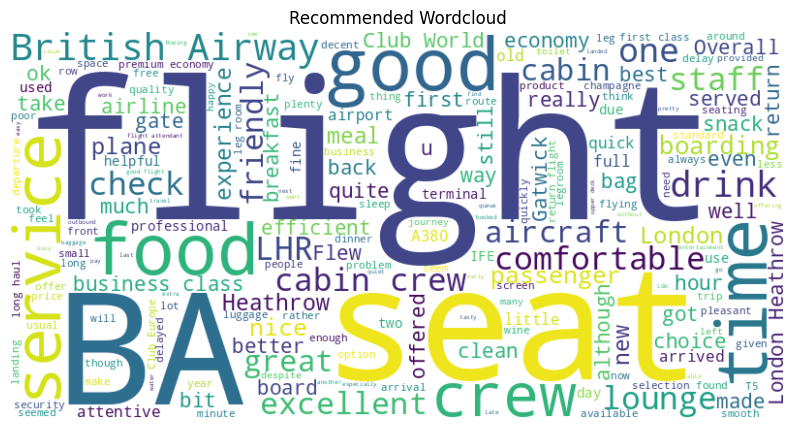

In [103]:
# same thing for recommended reviews
recommended = reviews_df[reviews_df['recommended']== 'yes']
# Concatenate all reviews into a single string
recommended_reviews = ' '.join(recommended['review_body'].tolist())
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(recommended_reviews)
# Display the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Recommended Wordcloud')
plt.show()

In [104]:
# save the cleaned data to the clean data folder
from src.paths import TRANSFORMED_DATA_DIR
reviews_df.to_parquet(TRANSFORMED_DATA_DIR / 'reviews_clean.parquet')

In [105]:
reviews_df['seat_type'].value_counts()

seat_type
Economy Class      2037
Business Class     1263
Premium Economy     376
First Class         216
Name: count, dtype: int64